In [1]:
CUDA_LAUNCH_BLOCKING="1"

In [2]:
#!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"

In [3]:
#!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git

In [4]:
#!pip install indic-nlp-library

In [5]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [6]:
import os
import sys

In [7]:
# path = '/content/gdrive/My Drive/'
# os.chdir(path)
print(os.getcwd())

/data/shrutis/anaconda


In [8]:
from __future__ import unicode_literals, print_function, division
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
print(torch.__version__)
# print(torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from io import open
import unicodedata
import string
import re
import random
import pandas as pd
from unicodedata import normalize
from nltk.tokenize import word_tokenize
from numpy import array
import numpy as np

1.8.1+cu102
cuda


In [9]:
#!pip install torch

In [10]:
print(torch.version.cuda)

10.2


In [11]:
# !pip uninstall torch torchvision -y
# !pip install torch torchvision

In [12]:
#To check if GPU is running or not
!nvidia-smi

/usr/bin/nvidia-modprobe: unrecognized option: "-f"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for
       usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-f"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for
       usage information.

Wed Mar 31 19:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 39%   67C   

In [13]:
!python -V

Python 3.7.3


In [14]:
#!nvcc --version

In [15]:
# import nltk
# nltk.download('punkt')

In [16]:
from indicnlp.tokenize import indic_tokenize 

In [17]:
from indicnlp.normalize.indic_normalize import DevanagariNormalizer
factory = DevanagariNormalizer()

In [18]:
SOS_token = 0
EOS_token = 1

#helper class
class Lang:
    def __init__(self, name):
        """ name are the list of phrases from each language"""
        self.name = name
        #word -> index dict
        self.word2index = {"SOS" : 0, "EOS" : 1}
        #count of each word to later replace rare words
        self.word2count = {}
        #index -> word dict
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS, EOS tokens
        self.max_seq_length = -1

    def addSentence(self, sentence):
        #Compute the maximum sequence length (useful for decoder)
        sentence_splitted = sentence.split(' ')
        if(len(sentence_splitted) > self.max_seq_length):
            self.max_seq_length = len(sentence_splitted)
        # update with individual tokens
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            # word to index mapping
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [70]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"here's": "here is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"y'all":"you all",
"let's": "let us"
}
# #Dictionary mapping contractions to word(s)

In [73]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(w):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿-])", r" \1 ", w)
    w = re.sub(r"[().!,?-]+", r" ", w)
    w = re.sub(r'[" "]+', " ", w) #multiple spaces
    w = w.lower().strip() #lowercase #Remove white spaces

    return w

In [48]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    regex = re.compile('[%s]' % re.escape(string.punctuation))

    for pair in lines:
        clean_pair = list()
        
        #cleaning hindi phrases
        line = pair[0]
        line = factory.normalize(line)
        tokens = list()
        for t in indic_tokenize.trivial_tokenize(line): 
            tokens.append(t)
        line = tokens
        line = [word.lower() for word in line]
        line = [word for word in line if not re.search(r'\d', word)]
        line = [regex.sub('', w) for w in line]
        #Replace the english characters
        line = [re.sub(r"[a-zA-Z]+?\s", "", w) for w in line]
        clean_pair.append(' '.join(line))

        #cleaning english phrases
        line = pair[1]
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        line = word_tokenize(line) 
        line = [word.lower() for word in line]
        #Convert to lowercase first as all our contractions are in lower case. 
        line = [regex.sub('', w) for w in line]
        #handle apostrophes !!!!!!
        line = [re.sub(r"[^a-zA-Z0-9?.!,¿\-\/']+", " ", w) for w in line]
        line = [re.sub(r" - ", "-", w) for w in line]
        line = [word for word in line if word.isalpha()]
        clean_pair.append(' '.join(line))
        
        cleaned.append(clean_pair)
    return array(cleaned)

In [49]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    # Read the file
    df = pd.read_csv("train.csv")
    #df.head(5)
    df1 = pd.read_csv("hindistatements.csv")

    # Split every line into pairs and normalize
    df["hindi"] = df.hindi.apply(lambda w: normalizeString(w))
    df1["hindi"] = df1.hindi.apply(lambda w: normalizeString(w))
    df["english"] = df.english.apply(lambda w: normalizeString(w))
    df['english'] = df['english'].replace(contractions,regex=True)

    pairs=[]
    for ind, r in df.iterrows():
        pairs.append([r['hindi'],r['english']])
    
    pairst=[]
    for ind, r in df1.iterrows():
        pairst.append([r['hindi'],""])

    #make Lang instances
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs, pairst

In [71]:
MAX_LENGTH_CUT_OFF = 100 #including ending punctuation , excluding start/end tokens

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH_CUT_OFF and len(p[1].split(' ')) <= MAX_LENGTH_CUT_OFF 


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [31]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs, pairst = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = clean_pairs(pairs)
    pairs = filterPairs(pairs)
    pairst = clean_pairs(pairst)
    pairst = filterPairs(pairst)
    print("Trimmed to %s sentence pairs" % len(pairs))
    #Make word lists from sentences in pairs
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in pairst:
        input_lang.addSentence(pair[0])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, pairst

In [75]:
### Load the training data 
input_lang, output_lang, pairs, pairst = prepareData('hindi', 'english')
print(random.choice(pairs))

Reading lines...
Read 102322 sentence pairs
Trimmed to 102298 sentence pairs
Counted words:
hindi 45413
english 29898
['विज्ञान के प्रति मेरा प्यार शुरू हुआ जब माता पिता ने मुझे एक कीचड़ रसायन सेट खरीदा और तब बढ़ गया था मेरी छठी श्रेणी की जीवविज्ञान कक्षा में सकल प्रयोग करके ।'
 'in fact my love of science itself began when my parents bought me a slime chemistry set and was then only enhanced by doing gross experiments in my sixth grade biology class']


In [76]:
print(random.choice(pairs))
# val_pairs = pairs[100000:]
# pairs = pairs[:100000]

from sklearn.model_selection import train_test_split

# split data into train and test set
pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state = 12)

['इसका निर्देशक अनाथालय को दान में प्राप्त पूरी धनराशि का गबन कर रहा था । और मेरी अनुपस्थिति में बच्चे इतने भारी उपेक्षित थे कि वे अपने पेट भरने के लिए चूहों को पकड़ने के लिए बाध्य थे ।'
 'the director had been embezzling every cent donated to the orphanage and in my absence the children were suffering such gross neglect that they were forced to catch mice to feed themselves']


In [61]:
pairs[20]

array(['गन क्लिक करके', 'gun clicking'], dtype='<U2021')

In [77]:
print('Test set size is : ', len(pairst))

Test set size is :  4999


In [78]:
print("maximum input sequence length : " , input_lang.max_seq_length)
print("maximum output sequence length : " , output_lang.max_seq_length)

maximum input sequence length :  99
maximum output sequence length :  95


In [79]:
print(random.choice(val_pairs))

['उदहारण के लिए महिला और पुरुष अपनी नाकामयाबी को अलग तरह से लेते हैं ।'
 'for instance that men and women react in a different way after the failure of a business']


In [80]:
#Return a list of indexes, one for each word in the sentence
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #append the EOS token to both sequences - enables the model to define a distribution over sequences of all possible lengths.
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    #input tensor - indexes of the words in the input sentence
    input_tensor = tensorFromSentence(input_lang, pair[0])
    #target tensor - indexes of the words in the target sentence
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

**Computation Graph of Encoder**

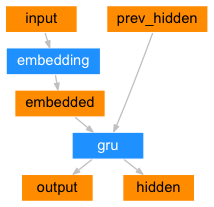

In [81]:
TARGET_MAX_LENGTH = output_lang.max_seq_length + 1 #since the we are adding the EOS and SOS tokens
print(TARGET_MAX_LENGTH)

INPUT_MAX_LENGTH = input_lang.max_seq_length + 1 #since the we are adding the EOS and SOS tokens
print(INPUT_MAX_LENGTH)

96
100


In [82]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False, method='GRU',verbose = False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_var = hidden_size // 2 if bidirectional else hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.n_directions = 2 if bidirectional else 1
        self.method = method
        self.verbose = verbose
        #An embedding to represent each word as a vector. Here our embedding length is 256
        self.embedding = nn.Embedding(input_size, hidden_size)

        if(self.method=='GRU'):
          # gru returns hidden state of all timesteps as well as hidden state at last timestep
          self.net = nn.GRU(hidden_size, hidden_size,num_layers=self.n_layers, bidirectional=self.bidirectional)
        elif self.method == 'LSTM':
          self.net = nn.LSTM(hidden_size,self.hidden_size, num_layers=self.n_layers,  bidirectional=self.bidirectional)  # out: tensor of shape (seq_length,batch_size,  hidden_size*n_directions)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        #Forward propagate
        output, hidden = self.net(output, hidden)

        if self.verbose:
            print('Encoder input', input.shape)
            print('Encoder output', output.shape)
            print('Encoder hidden', hidden.shape)

        return output, hidden

    def initHidden(self):
        if self.method == 'GRU':
          return torch.zeros(self.n_layers * self.n_directions, 1, self.hidden_size, device=device)
        elif self.method == 'LSTM':
          #Set initial states
          h_state = torch.zeros(self.n_layers * self.n_directions, 1, self.hidden_size, device=device)
          c_state = torch.zeros(self.n_layers * self.n_directions, 1, self.hidden_size, device=device)
          hidden = (h_state, c_state)
          return hidden

**Computation Graph of Decoder**

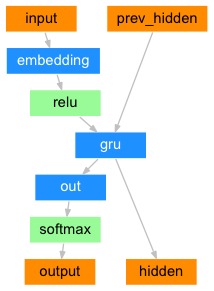

In [83]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [84]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=INPUT_MAX_LENGTH, method='GRU', bidirectional=False):
        super(AttnDecoderRNN, self).__init__()

        #Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.n_layers = n_layers
        self.method = method
        self.bidirectional = bidirectional

        #Define layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        #decoder’s input and hidden state as ip to attn layer
        self.attn = nn.Linear(self.hidden_size * 3, self.max_length)
        # self.attn = GeneralAttn(hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        if self.method == 'GRU':
            self.net = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.n_layers, bidirectional = self.bidirectional)
        elif self.method == 'LSTM':
            self.net = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.n_layers, bidirectional = self.bidirectional)

        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        #Embed - Get the embedding of the current input word (last output word)
        embedded = self.embedding(input).view(1, 1, -1)   # S=1 x B x N
        embedded = self.dropout(embedded)
        self.hidden = hidden

        # Concatenate all of the layers
        hidden_h_rows = ()
        hidden_c_rows = ()

        if self.method == 'LSTM':
            # hidden is a tuple of h_state and c_state
            decoder_h, decoder_c = hidden
            print(decoder_h.shape)
            hidden_shape = decoder_h.shape[0]

            # h_state
            for x in range(0, hidden_shape):
                hidden_h_rows += (decoder_h[x],)

            # c_state
            for x in range(0, hidden_shape):
                hidden_c_rows += (decoder_c[x],)

        elif self.method == "GRU":
              # Calculate attention weights and apply to encoder outputs 
              attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0], hidden[1]), 1)), dim=1)

              attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
              # Combine embedded input word and attended context, run through RNN
              output = torch.cat((embedded[0], attn_applied[0]), 1)
              output = self.attn_combine(output).unsqueeze(0)
              output = F.relu(output)

              output, hidden = self.net(output, hidden)
              # Final output layer
              #Decode the hidden state of the last time step
              # Normalize attention to weights in range 0 to 1, resize to 1 x 1 x seq_len
              output = F.log_softmax(self.out(output[0]), dim=1)
              #Return final output, hidden state, and attention weights (for visualization)
              return output, hidden, attn_weights

        if self.bidirectional:
                decoder_h_cat = torch.cat(hidden_h_rows, 1)
                # Make sure the h_dim size is compatible with num_layers with concatenation.
                decoder_h = decoder_h_cat.view((self.n_layers, 1, self.hidden_size))

                if self.method == "LSTM":
                    decoder_c_cat = torch.cat(hidden_c_rows, 1)
                    decoder_c = decoder_c_cat.view((self.n_layers, 1, self.hidden_size))
                    hidden_lstm = (decoder_h, decoder_c)

                    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_lstm[0][0]), 1)), dim=1)
        
                    #attention weights * encoder outputs = find inf abt specific part from i/p seq so decoder chooses right output words
                    attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

                    output = torch.cat((embedded[0], attn_applied[0]), 1)
                    output = self.attn_combine(output).unsqueeze(0)

                    output = F.relu(output)

                    output, hidden = self.net(output, hidden_lstm)
                     #Decode the hidden state of the last time step
                    output = F.log_softmax(self.out(output[0]), dim=1)
                    return output, hidden, attn_weights

    def initHidden(self):
        if self.method == 'GRU':
            return torch.zeros(self.n_layers * self.n_directions, 1, self.hidden_size, device=device)
        elif self.method == 'LSTM':
            h_state = torch.zeros(self.n_layers * 1, 1, self.hidden_size, device=device)
            c_state = torch.zeros(self.n_layers * 1, 1, self.hidden_size, device=device)
            hidden = (h_state, c_state)
            return hidden

In [85]:
n_layers=1
bidirectional = True
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=n_layers,  method='GRU', bidirectional=bidirectional).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=n_layers,method='GRU', bidirectional=bidirectional).to(device)

In [86]:
attn_decoder1

AttnDecoderRNN(
  (embedding): Embedding(29898, 256)
  (attn): Linear(in_features=768, out_features=100, bias=True)
  (attn_combine): Linear(in_features=768, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (net): GRU(256, 256, bidirectional=True)
  (out): Linear(in_features=512, out_features=29898, bias=True)
)

In [87]:
encoder1

EncoderRNN(
  (embedding): Embedding(45413, 256)
  (net): GRU(256, 256, bidirectional=True)
)

In [88]:
#This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [89]:
#Using teacher forcing causes it to converge faster
teacher_forcing_ratio = 0.5
#0.7
clip = 5.0

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_max_length=INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    # Zero gradients of both optimizers - Resetting
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    encoder_outputs = torch.zeros(input_max_length, encoder.hidden_size*2 , device=device) ## Changed

    loss = 0

    #Pass the input sentence through the ENCODER and keep track of every output and the latest hidden state
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    #decoder is given the <SOS> token as its first input
    decoder_input = torch.tensor([[SOS_token]], device=device)
    #decoder hidden state ("context vector" of input sentence ) ; last hidden state of the encoder as its first hidden state
    decoder_hidden = encoder_hidden

    #since using the "Teacher forcing" - passing the actual output sentence as the input to decoder
    if(random.random() < teacher_forcing_ratio):
      use_teacher_forcing = True
    else:
      use_teacher_forcing = False

    if use_teacher_forcing:
        #Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])     #For each decoder step (not the RNN step), compute the loss
            decoder_input = target_tensor[di]  # Teacher forcing via decoder_input

    else:
        #Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            #Get the index of best output word, and pass it as input to next decoder step
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    #backpropagate the loss 
    loss.backward()
    #Clipping the gradient after the backward pass
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    #apply the gradients using the optimization update step - update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/target_length

In [90]:
#torch.no_grad removes the ability to perform backprop (that's fine as we're 'evaluating' our model)
#but speeds up computation and reduces RAM consumption
def evaluate(encoder, decoder, pair, input_max_length = INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH):
    with torch.no_grad():

        #Prepare input and output tensors from the sentences
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        input_length = input_tensor.size()[0]
        target_length = target_tensor.size()[0]

        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        #Run through encoder
        #Generate the output sentence 
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(input_max_length, encoder.hidden_size*2, device=device) ## Changed

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] #BUG '+'

        #Create starting vectors for decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)  #SOS
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(input_max_length, input_max_length)

        #Run through decoder
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #store the decoder’s attention outputs
            decoder_attentions[di] = decoder_attention.data
            #Choose top word from output
            topv, topi = decoder_output.data.topk(1)

            loss += criterion(decoder_output, target_tensor[di]).item()

            #if prediction is EOS, STOP!!!
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])   #else add to output string 

            #feed the decoder’s predictions back to itself  - # Next input is chosen word
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions, loss/target_length

In [91]:
learning_rate=0.001
encoder_optimizer = optim.Adam(encoder1.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(attn_decoder1.parameters(), lr=learning_rate)

#lr=0.001, hidden - 256 -------- very bad!!!!!
# encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=learning_rate)

In [ ]:
encoder_optimizer

In [113]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

In [93]:
SAVE_PATH = './encoder_decoder_model_50.tar'

# #### General checkpoint saving for inference or resuming training
torch.save({
            'encoder_state_dict': encoder1.state_dict(),
            'attndecoder_state_dict': attn_decoder1.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),            
            'decoder_optimizer_state_dict' : decoder_optimizer.state_dict(),
            'criterion' : criterion.state_dict(),
            }, SAVE_PATH)

In [94]:
#to do plotting
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

In [95]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [96]:
def trainIters(encoder, decoder, encoder_optimizer , decoder_optimizer, n_iters, print_every=10000, plot_every=10000):
    # Keep track of time elapsed and running averages
    start = time.time()
    train_plot_losses = []
    val_plot_losses = []
    train_plot_bleu_scores = []
    val_plot_bleu_scores = []
    max_val_bleu_score = -1.0

    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print_bleu_total = 0

    training_pairs = []
    training_sentence_pairs = []

    # Get training data for this cycle
    for i in range(n_iters):
        sent_pair = random.choice(pairs)
        training_pairs.append(tensorsFromPair(sent_pair))
        #print(training_pairs)
        training_sentence_pairs.append(sent_pair)
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        # Run the train function
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_max_length = INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH )

        _, sent_bleu_score = evaluate_pairs(encoder , decoder, pairs = [training_sentence_pairs[iter-1]] )
        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss
        print_bleu_total += sent_bleu_score

        #Compute the loss and Bleu score on both the training and development set
        if iter % print_every == 0:
            #print loss 
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) Training-set loss: %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

            #print BLEU score 
            train_bleu_score = print_bleu_total/print_every
            print_bleu_total = 0
            print('Training set Bleu score : %.4f ' %(train_bleu_score) )

            ### --------------  Development set -------------###
            val_loss , val_bleu_score = evaluate_pairs(encoder, decoder, val_pairs, show_translation = False)

            #print loss 
            print('%s (%d %d%%) validation loss : %.4f' % (timeSince(start, iter / n_iters),iter, iter / n_iters * 100, val_loss))
            
            #print BLEU score
            print('Validation set Bleu score : %.4f ' %(val_bleu_score) )

            train_plot_losses.append(print_loss_avg)
            val_plot_losses.append(val_loss)
            train_plot_bleu_scores.append(train_bleu_score)
            val_plot_bleu_scores.append(val_bleu_score)
            print('')

            if val_bleu_score >= max_val_bleu_score:
                print('Saving the Best Model!!!')
                max_val_bleu_score = val_bleu_score
                BEST_SAVE_PATH = './encoder_decoder_model_best_50.tar'
                torch.save({
                            'encoder_state_dict': encoder.state_dict(),
                            'attndecoder_state_dict': decoder.state_dict(),
                            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),            
                            'decoder_optimizer_state_dict' : decoder_optimizer.state_dict(),
                            'criterion' : criterion.state_dict(),
                            }, BEST_SAVE_PATH)
    
    history = {'train_loss' : train_plot_losses,
               'val_loss': val_plot_losses,
               'train_bleu_score' : train_plot_bleu_scores,
               'val_bleu_score' : val_plot_bleu_scores
               }

    return history

In [114]:
def evaluate_pairs(encoder, decoder, pairs, show_translation = False):
    n = len(pairs)
    #Compute the average bleu score 

    bleu_scores_list = []
    loss_list = []

    for i in range(n):
        # pair = random.choice(pairs)
        pair = pairs[i]
        
        output_words, attentions, loss_value  = evaluate(encoder, decoder, pair, input_max_length = INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH )
        output_sentence = ' '.join(output_words)

        # f1.writelines(pair[0]+","+output_sentence+"\n")

        if show_translation == True:
            print('Hindi sentence : ', pair[0])
            print('English sentence : ', pair[1])
            print('Predicted sentence : ', output_sentence)

        actual_sent_splitted = pair[1].split()
        output_sent_splitted = output_sentence.split()
        
        smoothing_function = SmoothingFunction().method4
        sent_bleu_score = 0.0

        try:
          sent_bleu_score = sentence_bleu(references = [actual_sent_splitted] , hypothesis = output_sent_splitted , weights = (0.25, 0.25, 0.25, 0.25), smoothing_function =  smoothing_function )
        except:
          pass

        bleu_scores_list.append(sent_bleu_score)
        loss_list.append(loss_value)

    avg_bleu_score = np.nanmean(bleu_scores_list, )
    avg_loss_value = np.nanmean(loss_list)
    # print('Bleu score is : ', avg_bleu_score )
    # print('')
    return avg_loss_value, avg_bleu_score

In [115]:
%matplotlib inline

training_history = trainIters(encoder = encoder1, decoder = attn_decoder1, 
                              encoder_optimizer = encoder_optimizer, decoder_optimizer = decoder_optimizer,
                              n_iters = 20000, print_every=1000)

2m 29s (- 47m 16s) (1000 5%) Training-set loss: 4.5725
Training set Bleu score : 0.1752 
3m 42s (- 70m 34s) (1000 5%) validation loss : 4.2831
Validation set Bleu score : 0.1549 

Saving the Best Model!!!
5m 49s (- 52m 28s) (2000 10%) Training-set loss: 4.6797
Training set Bleu score : 0.1732 
7m 0s (- 63m 4s) (2000 10%) validation loss : 4.1539
Validation set Bleu score : 0.1498 

9m 2s (- 51m 15s) (3000 15%) Training-set loss: 4.5595
Training set Bleu score : 0.1725 
10m 16s (- 58m 10s) (3000 15%) validation loss : 4.3112
Validation set Bleu score : 0.1572 

Saving the Best Model!!!
12m 23s (- 49m 35s) (4000 20%) Training-set loss: 4.7693
Training set Bleu score : 0.1628 
13m 31s (- 54m 7s) (4000 20%) validation loss : 3.9990
Validation set Bleu score : 0.1465 

15m 36s (- 46m 49s) (5000 25%) Training-set loss: 4.4634
Training set Bleu score : 0.1739 
16m 49s (- 50m 29s) (5000 25%) validation loss : 4.3638
Validation set Bleu score : 0.1577 

Saving the Best Model!!!
18m 48s (- 43m 5

In [ ]:
# hidden_size=256
# n_layers=1
# bidirectional=True

In [116]:
# device = torch.device('cpu')
encoder_loaded = EncoderRNN(input_lang.n_words, hidden_size, n_layers=n_layers,  method='GRU', bidirectional=bidirectional)
attn_decoder_loaded= AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=n_layers,method='GRU', bidirectional=bidirectional)
#Load the dictionary from saved file
BEST_SAVE_PATH = './encoder_decoder_model_best_50.tar'
checkpoint = torch.load(BEST_SAVE_PATH)

# load the state from dictionary 
encoder_loaded.load_state_dict(checkpoint['encoder_state_dict'])
attn_decoder_loaded.load_state_dict(checkpoint['attndecoder_state_dict'])

encoder_loaded.train()
attn_decoder_loaded.train()

encoder_loaded = encoder_loaded.to(device)
attn_decoder_loaded = attn_decoder_loaded.to(device)

# learning_rate=0.001
# encoder_optimizer_loaded = optim.Adam(encoder_loaded.parameters(), lr=learning_rate)
# decoder_optimizer_loaded = optim.Adam(attn_decoder_loaded.parameters(), lr=learning_rate)

In [ ]:
device = torch.device('cuda')

In [ ]:
# from collections import defaultdict
# file1 = pd.read_csv("hindistatements.csv")[40:50]
# file1["hindi"] = file1.hindi.apply(lambda w: normalizeString(w))
# pairs1=[]
# for ind, r in file1.iterrows():
#   pairs1.append([r['hindi'],"NONE"])

# print("Read %s sentence pairs" % len(pairs1))
# pairs1 = clean_pairs(pairs1)
# pairs1 = filterPairs(pairs1)
# print("Trimmed to %s sentence pairs" % len(pairs1))
# #Make word lists from sentences in pairs
# for pair in pairs1:
#     input_lang.addSentence(pair[0])
# #     output_lang.addSentence(pair[1])
# # print("Counted words:")
# print(input_lang.name, input_lang.n_words)
# print(output_lang.name, output_lang.n_words)

In [117]:
def evaluate1(encoder, decoder, sentence, max_length=INPUT_MAX_LENGTH,  target_max_length = TARGET_MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
#         input_tensor = input_tensor.to(device)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size*2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(target_max_length, target_max_length)

        for di in range(target_max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
#             decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        #print(decoded_words)
        return decoded_words

In [123]:
f1= open("answer1.txt",'w')

In [119]:
def evaluateRandomly(encoder, decoder, pairs1):
    for i in range(len(pairs1)):
        pair = pairs1[i]
        # pair = random.choice(pairs)
        #print('>',pair[0])
        output_words = evaluate1(encoder, decoder,pair[0])
        output_sentence = ' '.join(output_words[:-1])
        f1.writelines(output_sentence+"\n")
        #print('<', output_sentence)
        #print('')

In [124]:
evaluateRandomly(encoder1, attn_decoder1, pairst)

In [ ]:
pairst[:2]

<Figure size 432x288 with 0 Axes>

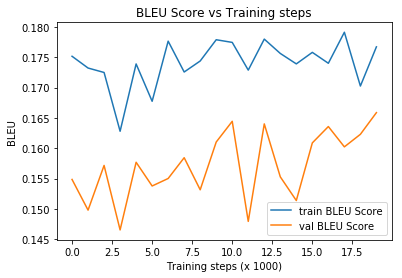

In [121]:
## PLot the train and validation bleu score
plt.figure()
fig, ax = plt.subplots() 
plt.plot(training_history['train_bleu_score'], label = 'train BLEU Score')
plt.plot(training_history['val_bleu_score'], label = 'val BLEU Score')
plt.title('BLEU Score vs Training steps')
plt.xlabel('Training steps (x 1000)')
plt.ylabel('BLEU')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

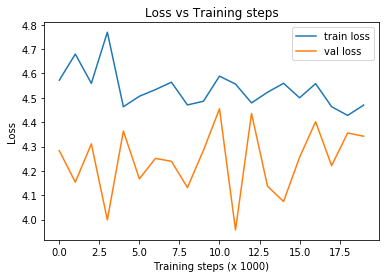

In [122]:
## PLot the train and validation loss 
plt.figure()
fig, ax = plt.subplots()
plt.plot(training_history['train_loss'], label = 'train loss')
plt.plot(training_history['val_loss'], label = 'val loss')
plt.title('Loss vs Training steps')
plt.xlabel('Training steps (x 1000)')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(random.choice(pairs1))

In [ ]:
test_loss , test_bleu_score = evaluate_pairs(encoder = encoder1, decoder = attn_decoder1, pairs = pairs1[5:15], show_translation = True)

In [ ]:
f1.close()

In [ ]:
SAVE_PATH = './encoder_decoder_model_best_50.tar'

In [ ]:
# ##  Load the dictionary from saved file
checkpoint = torch.load(SAVE_PATH)

# load the state from dictionary 
encoder1.load_state_dict(checkpoint['encoder_state_dict'])
attn_decoder1.load_state_dict(checkpoint['attndecoder_state_dict'])

In [ ]:
encoder1.train().to(device)
attn_decoder1.train().to(device)

In [ ]:
# encoder_loaded = EncoderRNN(input_lang.n_words, hidden_size)
# attn_decoder_loaded = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

In [ ]:
# learning_rate=0.0002
# encoder_optimizer_loaded = optim.Adam(encoder_loaded.parameters(), lr=learning_rate)
# decoder_optimizer_loaded = optim.Adam(attn_decoder_loaded.parameters(), lr=learning_rate)

In [ ]:
# TRAIN_LOADED_MODEL = False

In [ ]:
# # Important to do the following step to freeze the layers and use the model for evaluation
# encoder_loaded.eval()
# attn_decoder_loaded.eval()

# ##  Load the dictionary from saved file
# checkpoint = torch.load(SAVE_PATH)

# # load the state from dictionary 
# encoder_loaded.load_state_dict(checkpoint['encoder_state_dict'])
# attn_decoder_loaded.load_state_dict(checkpoint['attndecoder_state_dict'])

# if TRAIN_LOADED_MODEL:
#   encoder_loaded.train()
#   attn_decoder_loaded.train()
# else: 
#   encoder_loaded.eval()
#   attn_decoder_loaded.eval()

# encoder_loaded = encoder_loaded.to(device)
# attn_decoder_loaded = attn_decoder_loaded.to(device)

In [ ]:
#Set "show_translation" = True to show the translated sentences for each test sentence

#test_loss , test_bleu_score = evaluate_pairs(encoder = encoder1, decoder = attn_decoder1, pairs = val_pairs[100:105], show_translation = True)

In [ ]:
#print("Bleu score on test set using best checkpoint (in percent): ", round(test_bleu_score*100, 4 ) )